# Titanic Uçtan Uca Feature Engineering & Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data

def load():
    data = pd.read_csv("titanic.csv")
    return data

def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [2]:
df = load()
df.shape

(891, 12)

In [3]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [4]:
# 1. Feature Engineering (Değişken Mühendisliği)

# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [6]:
# 2. Outliers (Aykırı Değerler)

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True
AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [7]:
# 3. Missing Values (Eksik Değerler)

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
        
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [8]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,65.634,C85,C,1,45,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [9]:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [10]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,65.634,C85,C,1,45,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [11]:
missing_values_table(df)

       n_miss  ratio
CABIN     687 77.100


In [12]:
# 4. Label Encoding
df.columns = [col.upper() for col in df.columns]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

binary_cols

['SURVIVED', 'SEX', 'NEW_NAME_DR', 'NEW_IS_ALONE']

In [13]:
# 5. Rare Encoding

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

        
rare_analyser(df, "SURVIVED", cat_cols)

df = rare_encoder(df, 0.01)

df["NEW_TITLE"].value_counts()

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339


NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             7  0.008        0.429
Jonkheer       1  0.001        0.000
Lady           1  0.001        1.000
Major          2  0.002        0.500
Master        40  0.045        0.575
Miss         182  0.204        0.698
Mlle           2  0.002        1.000
Mme            1  0.001        1.000
Mr           517  0.580        0.157
Mrs          125  0.140        0.792
Ms             1  0.001        1.000
Rev            6  0.007    

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

In [14]:
# 6. One-Hot Encoding

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

df.head()

,PASSENGERID,SURVIVED,NAME,SEX,AGE,TICKET,FARE,CABIN,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,Rare,1,22.000,Rare,7.250,NaN,0,23,0,66.000,0,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1,2,1,Rare,0,38.000,Rare,65.634,Rare,1,45,0,38.000,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,3,1,Rare,0,26.000,Rare,7.925,NaN,0,22,0,78.000,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,4,1,Rare,0,35.000,Rare,53.100,Rare,1,44,0,35.000,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
4,5,0,Rare,1,35.000,Rare,8.050,NaN,0,24,0,105.000,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


In [15]:
df.shape

(891, 64)

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

rare_analyser(df, "SURVIVED", cat_cols)

Observations: 891
Variables: 64
cat_cols: 59
num_cols: 5
cat_but_car: 0
num_but_cat: 56
NAME : 1
      COUNT  RATIO  TARGET_MEAN
NAME                           
Rare    891  1.000        0.384


TICKET : 1
        COUNT  RATIO  TARGET_MEAN
TICKET                           
Rare      891  1.000        0.384


CABIN : 1
       COUNT  RATIO  TARGET_MEAN
CABIN                           
Rare     204  0.229        0.667


SURVIVED : 2
          COUNT  RATIO  TARGET_MEAN
SURVIVED                           
0           549  0.616        0.000
1           342  0.384        1.000


SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


NEW_CABIN_BOOL : 2
                COUNT  RATIO  TARGET_MEAN
NEW_CABIN_BOOL                           
0                 687  0.771        0.300
1                 204  0.229        0.667


NEW_NAME_DR : 2
             COUNT  RATIO  TARGET_MEAN
NEW_NAME_DR                           
0  

In [17]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

# df.drop(useless_cols, axis=1, inplace=True)

# iki sınıflı olup sınıflardan biri 0.01den az değer bulunduranları
# anlam ifade etmediği için çıkardık 

In [18]:
# 7. Standart Scaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.561,-0.821,-0.437,0.066
1,0.663,2.032,2.248,-0.790
2,-0.255,-0.788,-0.559,0.434
3,0.434,1.419,2.126,-0.882
4,0.434,-0.781,-0.315,1.260


In [19]:
df.head()

,PASSENGERID,SURVIVED,NAME,SEX,AGE,TICKET,FARE,CABIN,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,Rare,1,-0.561,Rare,-0.821,NaN,0,-0.437,0,0.066,0,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1,2,1,Rare,0,0.663,Rare,2.032,Rare,1,2.248,0,-0.790,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,3,1,Rare,0,-0.255,Rare,-0.788,NaN,0,-0.559,0,0.434,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,4,1,Rare,0,0.434,Rare,1.419,Rare,1,2.126,0,-0.882,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
4,5,0,Rare,1,0.434,Rare,-0.781,NaN,0,-0.315,0,1.260,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


In [20]:
df.shape

(891, 64)

In [21]:
df = df.drop(df.columns[df.apply(lambda col: 'Rare' in col.values)].tolist(), axis=1)
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,-0.561,-0.821,0,-0.437,0,0.066,0,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1,2,1,0,0.663,2.032,1,2.248,0,-0.790,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,3,1,0,-0.255,-0.788,0,-0.559,0,0.434,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,4,1,0,0.434,1.419,1,2.126,0,-0.882,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
4,5,0,1,0.434,-0.781,0,-0.315,0,1.260,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


In [22]:
# 8. Model

y = df["SURVIVED"]   # bağımlı değişken
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)  # bağımsız değişkenler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [24]:
y_pred = rf_model.predict(X_test)

accuracy_score(y_pred, y_test)

0.7910447761194029

In [25]:
# Hiç bir işlem yapılmadan elde edilecek skor?

dff = load()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7090909090909091

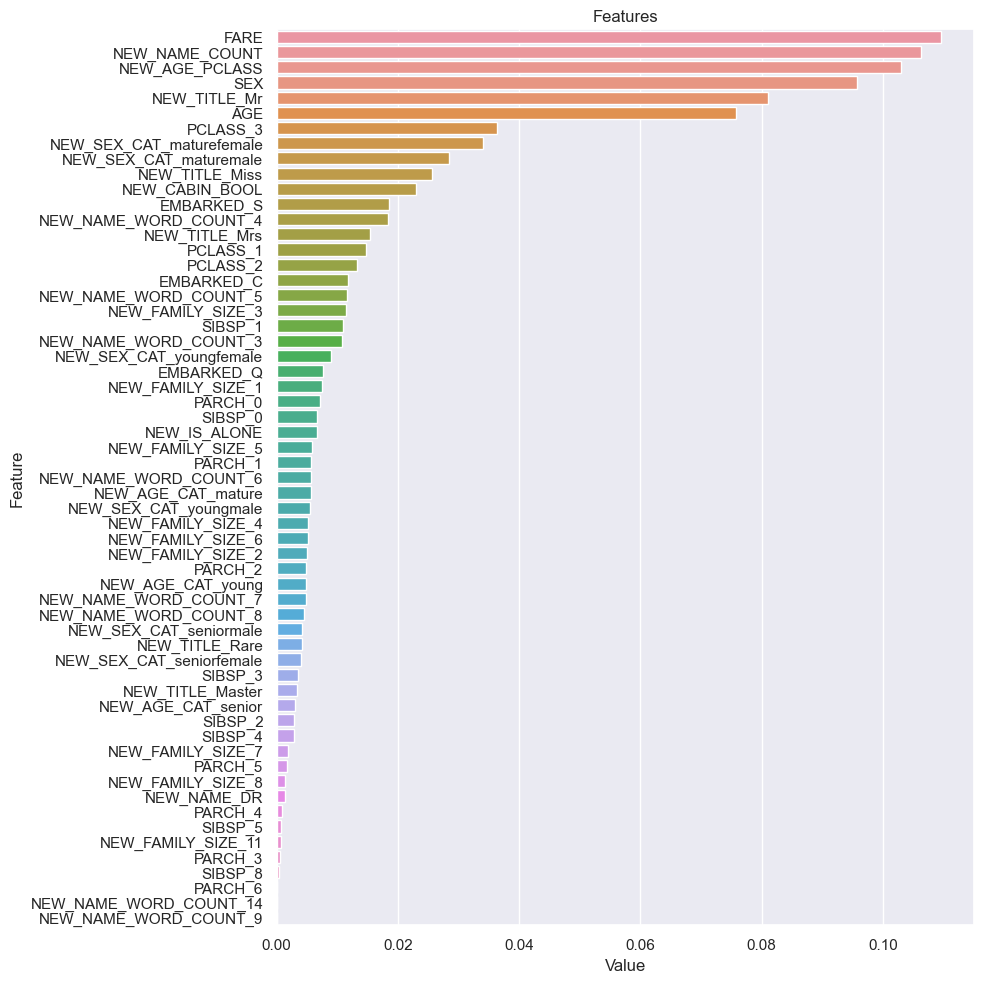

In [26]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


y = df["SURVIVED"]   # bağımlı değişken
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)  # bağımsız değişkenler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)


plot_importance(rf_model, X_train)